<a href="https://colab.research.google.com/github/mongabra/AI-week_7/blob/main/AI_Fairness_week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Cell 1: Setup and Dependencies (Refined)

# Install AIF360 and necessary extensions
!pip install 'aif360[all]'
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install 'tensorflow>=2.0'

In [10]:
import pandas as pd

# Load the uploaded COMPAS CSV file
df = pd.read_csv('/content/compas-scores-two-years.csv')

# Preview the dataset
print("Dataset loaded successfully!")
df.head()


Dataset loaded successfully!


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [16]:
# Cell 3: Data Preprocessing, Manual Encoding, AIF360 Conversion, Scaling, and Baseline Model Training (FINAL FIX - Label Type)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.datasets import BinaryLabelDataset

# --- 1. Data Preprocessing (Filtering and Feature Selection) ---

# Filter and select features as per the ProPublica analysis:
df_clean = df[(df.days_b_screening_arrest <= 30) &
              (df.days_b_screening_arrest >= -30) &
              (df.is_recid != -1) &
              (df.c_charge_degree != 'O') &
              (df.score_text != 'N/A') &
              (df.race.isin(['African-American', 'Caucasian']))].copy()

# Select final features
selected_features = [
    'sex', 'age', 'race', 'priors_count', 'c_charge_degree',
    'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'two_year_recid'
]
df_clean = df_clean[selected_features]

# --- 2. Manual One-Hot Encoding and Label Type Fix (THE CRITICAL FIXES) ---

label_name = 'two_year_recid'

# FIX 1: Convert label column to float to match AIF360's internal expectation (0.0 and 1.0)
df_clean[label_name] = df_clean[label_name].astype(float)

# FIX 2: Manual One-Hot Encoding for categorical string columns
categorical_cols = ['sex', 'c_charge_degree', 'race']
df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# --- 3. AIF360 BinaryLabelDataset Creation ---

favorable_label = 0.0  # Must be float
unfavorable_label = 1.0 # Must be float
protected_attribute_names = ['race_Caucasian']

# FIX 3: Ensure attribute names are iterable (list of lists)
privileged_protected_attributes = [[1.0]]
unprivileged_protected_attributes = [[0.0]]

# Create the AIF360 BinaryLabelDataset
dataset_orig = BinaryLabelDataset(
    df=df_clean,
    label_names=[label_name],
    favorable_label=favorable_label,
    unfavorable_label=unfavorable_label, # Explicitly pass unfavorable label
    protected_attribute_names=protected_attribute_names,
    privileged_protected_attributes=privileged_protected_attributes,
    unprivileged_protected_attributes=unprivileged_protected_attributes
)

# Split the dataset into train and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

# Define groups for metrics (based on the encoded column 'race_Caucasian')
unprivileged_groups = [{'race_Caucasian': 0.0}]
privileged_groups = [{'race_Caucasian': 1.0}]

# --- 4. Feature Scaling and Model Training ---

# Separate and standardize features
scale = StandardScaler()
X_train = scale.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
X_test = scale.transform(dataset_orig_test.features)

# Train the Baseline Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Predict labels on the test set and prepare the prediction dataset
y_pred = model.predict(X_test)
dataset_pred = dataset_orig_test.copy(deepcopy=True)
dataset_pred.labels = y_pred.reshape(-1, 1)

# Evaluate overall model accuracy
acc = accuracy_score(dataset_orig_test.labels, y_pred)
print(f"Baseline Model Accuracy: {acc:.4f}")
print("Data successfully preprocessed, scaled, and baseline model trained.")

Baseline Model Accuracy: 0.6755
Data successfully preprocessed, scaled, and baseline model trained.


--- Bias Audit Findings (Baseline Model) ---
False Positive Rate (Privileged - Caucasian): 0.6320
False Positive Rate (Unprivileged - African-American): 0.3383
FPR Difference (Unprivileged - Privileged): -0.2937 (Goal: 0.0)
Disparate Impact (DI): 0.6381 (Goal: 1.0)
Average Odds Difference (AOD): -0.2411 (Goal: 0.0)


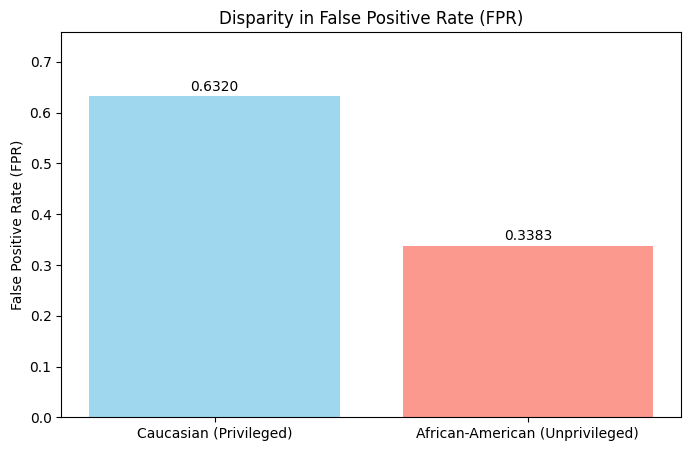

In [17]:
# Cell 4: Compute Fairness Metrics and Visualize FPR Disparity

from aif360.metrics import ClassificationMetric
import matplotlib.pyplot as plt

# Instantiate the ClassificationMetric
metric = ClassificationMetric(
        dataset_orig_test,
        dataset_pred,
        unprivileged_groups=unprivileged_groups, # Inherited from Cell 3 (race_Caucasian: 0.0)
        privileged_groups=privileged_groups      # Inherited from Cell 3 (race_Caucasian: 1.0)
    )

# --- Compute and Print Key Metrics ---
# FPR: False Positive Rate (False Alarms) = FP / (FP + TN)
fpr_priv = metric.false_positive_rate(privileged=True)
fpr_unpriv = metric.false_positive_rate(privileged=False)
fpr_diff = fpr_unpriv - fpr_priv

print("--- Bias Audit Findings (Baseline Model) ---")
print(f"False Positive Rate (Privileged - Caucasian): {fpr_priv:.4f}")
print(f"False Positive Rate (Unprivileged - African-American): {fpr_unpriv:.4f}")
print(f"FPR Difference (Unprivileged - Privileged): {fpr_diff:.4f} (Goal: 0.0)")
print(f"Disparate Impact (DI): {metric.disparate_impact():.4f} (Goal: 1.0)")
print(f"Average Odds Difference (AOD): {metric.average_odds_difference():.4f} (Goal: 0.0)")

# --- Visualization ---
groups = ['Caucasian (Privileged)', 'African-American (Unprivileged)']
fpr_values = [fpr_priv, fpr_unpriv]
colors = ['skyblue', 'salmon']

plt.figure(figsize=(8, 5))
bars = plt.bar(groups, fpr_values, color=colors, alpha=0.8)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

plt.title('Disparity in False Positive Rate (FPR)')
plt.ylabel('False Positive Rate (FPR)')
plt.ylim(0, max(fpr_values) * 1.2)
plt.show()

In [18]:
# Cell 5: Bias Mitigation (Reweighing) and Re-evaluation

from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.metrics import ClassificationMetric

# The unprivileged_groups and privileged_groups definitions are inherited from Cell 3

# 1. Initialize the Reweighing algorithm
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

# 2. Transform the training data by adjusting sample weights
# dataset_orig_train is the original, pre-scaled AIF360 training dataset
dataset_transf_train = RW.fit_transform(dataset_orig_train)

# Get the new sample weights to be used in training
sample_weights = dataset_transf_train.instance_weights.ravel()

# 3. Retrain the model using the new weights (X_train and y_train are scaled features from Cell 3)
model_mitigated = LogisticRegression(solver='liblinear', random_state=42)
# The sample_weight parameter applies the reweighing transformation
model_mitigated.fit(X_train, y_train, sample_weight=sample_weights)

# 4. Predict and convert to AIF360 Dataset
y_pred_mitigated = model_mitigated.predict(X_test)
dataset_pred_mitigated = dataset_orig_test.copy(deepcopy=True)
dataset_pred_mitigated.labels = y_pred_mitigated.reshape(-1, 1)

# 5. Compute fairness metrics on the mitigated model
metric_mitigated = ClassificationMetric(
    dataset_orig_test,
    dataset_pred_mitigated,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# --- Comparison of Results ---
# Recalculate baseline metrics for the final printout, using variables from Cell 4
fpr_diff = metric.false_positive_rate(False) - metric.false_positive_rate(True)
acc = accuracy_score(dataset_orig_test.labels, y_pred)

# Calculate mitigated metrics
fpr_diff_mitigated = metric_mitigated.false_positive_rate(False) - metric_mitigated.false_positive_rate(True)
acc_mitigated = accuracy_score(dataset_orig_test.labels, y_pred_mitigated)

print("--- Comparison of Key Metrics (Baseline vs. Mitigated) ---")
print(f"| Metric | Baseline | Mitigated | Goal |")
print(f"| :--- | :---: | :---: | :---: |")
print(f"| Accuracy | {acc:.4f} | {acc_mitigated:.4f} | N/A |")
print(f"| Disparate Impact (DI) | {metric.disparate_impact():.4f} | {metric_mitigated.disparate_impact():.4f} | 1.0 |")
print(f"| **FPR Difference** | **{fpr_diff:.4f}** | **{fpr_diff_mitigated:.4f}** | **0.0** |")
print(f"| Avg Odds Diff (AOD) | {metric.average_odds_difference():.4f} | {metric_mitigated.average_odds_difference():.4f} | 0.0 |")

--- Comparison of Key Metrics (Baseline vs. Mitigated) ---
| Metric | Baseline | Mitigated | Goal |
| :--- | :---: | :---: | :---: |
| Accuracy | 0.6755 | 0.6547 | N/A |
| Disparate Impact (DI) | 0.6381 | 1.0253 | 1.0 |
| **FPR Difference** | **-0.2937** | **0.0652** | **0.0** |
| Avg Odds Diff (AOD) | -0.2411 | 0.0613 | 0.0 |
